# Advanced Lane Finding 


Stages:

1. Calculate Camera Calibration Matrix

2. Apply Distortion Correction
3. Perform appropriate colour transformations 
4. Adjust perspective to get Bird's Eye View
5. Perform Lane Detection
6. Calculate curvature
7. Warp back to original image
8. Output Image

1 is a pre-processing step, while 2-8 indicate our processing pipeline

In [5]:
## Import Libraries

import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [6]:
# Calculate Camera Distortion Matrix

# This is performed in a seperate notebook and the numbers brought in.
dist_pickle = pickle.load( open( "cameracal.p", "rb" ) )

mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# undist = cv2.undistort(img, mtx, dist, None, mtx)

In [30]:
# PipeLine

def PipeLine(img):
    
    # 2 Distortion
    #img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # 3 Colour Transforms
    
    # Take the saturation channel only
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]

    # Set Threshold and create output
    thresh = (90, 255)
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    # S is a good channel for lines but R is sometimes better on white lines. 
    # You could take S channel + R channel where colour is near White?
    
    img = binary
    
    # 4 Adjust to Bird's Eye
    xsize = 1280
    ysize = 720
    
    # Points are TL, TR, BL, BR
    src = np.float32([[595,440],[685,440],[100,670],[1180,670]])
    dst = np.float32([[0,0],[xsize,0],[0,ysize],[xsize,ysize]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src) 
    warped = cv2.warpPerspective(img, M, (xsize,ysize), flags=cv2.INTER_LINEAR)
    
    # 5 Lane Detection
    #result = search_around_poly(warped)
    
    # 6 Calculate Curvature
    

    # 7 Warp back to Original
    img = cv2.warpPerspective(warped, Minv, (xsize,ysize), flags=cv2.INTER_LINEAR)
    #img = warped
    
    # 8 return image
    return img
    

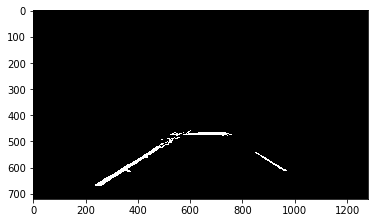

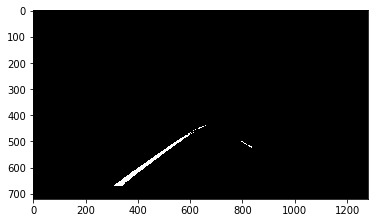

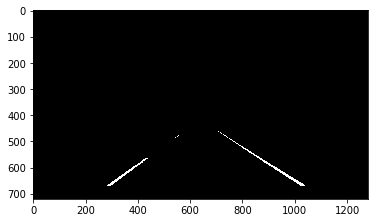

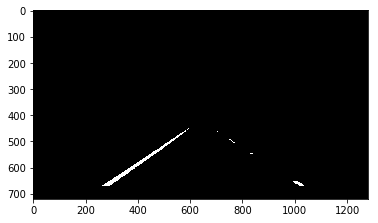

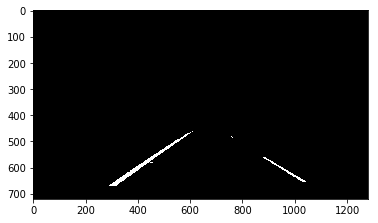

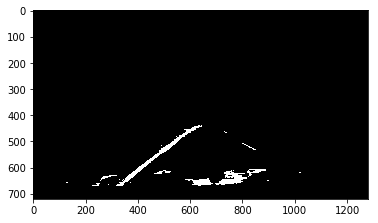

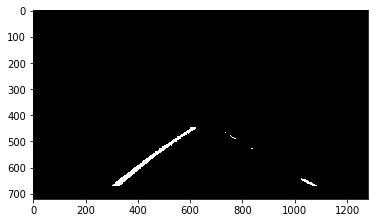

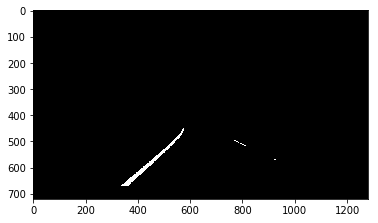

In [32]:
# Run Pipeline on all the TEST Images

for i, filename in enumerate(os.listdir("test_images/")):
      
    # Load Image and process
    image = mpimg.imread("test_images/" + filename)
    outimage = PipeLine(image)
    # Save Image
    #cv2.imwrite('test_images_output/' + filename, outimage)
    plt.imshow(outimage, cmap='gray')
    plt.show()

In [ ]:
# These are the functions to find the lines using a sliding window 

# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(binary_warped)

# View your output
plt.imshow(result)
